# Xenia's Sleep Analysis Code for up to 3 groups

This code is designed to be run in one fell swoop with all the preparation needed being done in the first few lines. If the amount of groups is different than here, you may need to change stuff - otherwise it should work.

## 1) Import Statements

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statistics as stats
import scipy.stats as ss
import os
import datetime
import scikit_posthocs as sp #requires at least version 1.16.0

## User Instructions
Please input filepaths to the FOLDER containing your data for a specific condition in the cell below. The folder should in turn contain the **folders** with your pre-analized (Matlab) Sleep Analysis data.

Example:

"Controls" 
    <br>> "2025_10_13_Control_Box1"</br>
       > "2025_10_14_Control_Box1"
    <br>> "2025_10_15_Control_Box1"</br>
   ... etc.

Ideally, this is the only cell you need to interact with. 

All results will be saved to the path you specify as "path_graphics", including the results of the t-tests in a .txt file. Aside from adding groups (or unprecedented errors) there are no real reasons for you to interact with other cells.

In [2]:
#Which time did you use for binning? (In Matlab)
binned = 2 #in minutes
'''Which limit to set for the y-axis on the graphics?'''
lim_y = 45 #for sleep
lim_y_wake = 15
'''Limits to set for bar plots'''
lim_y_bp_sleep = 60
lim_y_bp_wake = 15

#How many groups are there (including the control)? (Currently supports 2 or 3)
group_nr = 2
#Which names do you want to give your groups? (strings)
ctrl_name = "control"
group_1_name = "continuous light"
group_2_name = ""

'''Statistische Tests alle Kruskal-Wallis Tests?'''
#Only relevant if you have >2 group_nr
## Change to True if later tests were Kruskal-Wallis and automatic recognition for first tests gave ANOVA
## Or if you just want all of them to be Kruskal-Wallis tests without testing for ANOVA possibility
kruskal_var = False #boolean, default: False

#filepaths for the folder containing your group data
ctrl_filepath = r"C:\Users\xringwal\Desktop\Xenia\WorkingMem\Comparison\Sleep Data\Control"
grp1_filepath = r"C:\Users\xringwal\Desktop\Xenia\WorkingMem\Comparison\Sleep Data\ContinuousLight"
#grp2_filepath = r""


#This is where you'll save your graphics in the last step
path_graphics = r"C:\Users\xringwal\Desktop\Xenia\WorkingMem\Comparison\Sleep Data\Pooled_graphics"

In [3]:
# set up output file for t-test data
name_of_file = "statistics_output"
output_file = os.path.join(path_graphics, name_of_file+".txt") 

x = datetime.datetime.now()

with open(output_file, "w") as f:
    f.write("Output from: "+x.strftime("%d"+" "+"%b"+" "+"%Y")+"\n") #adds date to output file

In [4]:
#Define the statistics function
def statistics(kruskal_var=False, output_file, list_dfs, list_names):
    #Levene's Test (tests for equal variances)
    with open(output_file, "a") as f:
        f.write("\n"+"Levene's Test (for equal variances) using median (see Brown-Forsythe)"+"\n")
    if len(list_dfs) == 2:
        df1 = list_dfs[0]
        df2 = list_dfs[1]
        name1 = str(list_names[0])
        name2 = str(list_names[1])
        levene_stat, levene_p=ss.levene(df1, df2)
        with open(output_file, "a") as f:
            f.write("Included groups: "+str(name1)+" & "+str(name2)+"\n")
            f.write("Stat: "+str(levene_stat)+" p-value: "+str(levene_p)+"\n")
    elif len(list_dfs) == 3:
        df1 = list_dfs[0]
        df2 = list_dfs[1]
        df3 = list_dfs[2]
        name1 = str(list_names[0])
        name2 = str(list_names[1])
        name3 = str(list_names[2])
        levene_stat, levene_p=ss.levene(df1, df2, df3)
        with open(output_file, "a") as f:
            f.write("Included groups: "+str(name1)+" & "+str(name2)+" & "+str(name3)+"\n")
            f.write("Stat: "+str(levene_stat)+" p-value: "+str(levene_p)+"\n")   
    
    if levene_p > 0.05:
        var_equality=True
    else:
        var_equality=False
        
    #independent t-test for 2 groups
    if group_nr ==2:
        p = ss.ttest_ind(df1, df2, equal_var=var_equality)
        print(str(name1)+" vs "+str(name2)+" p: ", p)
        if levene_p > 0.5:
            test = "standard independent t-test"
        else:
            test = "Welch's independent t-test"
        with open(output_file, "a") as f:
            f.write("\n"+test+"\n")
            f.write(str(name1)+" vs "+str(name2)+"\n"+ str(p)+"\n")
    
    if len(list_dfs) >=3:
        '''Are the conditions for an ANOVA met?'''
        #Test for normality using a Shapiro-Wilk test for n<5000 and the scipy normaltest for larger n
        if len(df1)<5000 and len(df2)<5000 and len(df3)<5000:
            with open(output_file, "a") as f:
                f.write("\nTest for normal distribution (Shapiro-Wilk test):\n")
            stat_normal_control, p_normal_control = ss.shapiro(df1)
            stat_normal_grp1, p_normal_grp1 = ss.shapiro(df2)
            stat_normal_grp2, p_normal_grp2 = ss.shapiro(df3)
        else:
            with open(output_file, "a") as f:
                f.write("\nTest for normal distribution (scipy normaltest D'Agostino and Pearson's):\n")
            stat_normal_control, p_normal_control = ss.normaltest(df1)
            stat_normal_grp1, p_normal_grp1 = ss.normaltest(df2)
            stat_normal_grp2, p_normal_grp2 = ss.normaltest(df3)
        with open(output_file, "a") as f:
            f.write(str(name1)+": \n")
            f.write("Stat: "+str(stat_normal_control)+" p-value: "+str(p_normal_control)+"\n")
            f.write(str(name2)+": \n")
            f.write("Stat: "+str(stat_normal_grp1)+" p-value: "+str(p_normal_grp1)+"\n")
            f.write(str(name3)+": \n")
            f.write("Stat: "+str(stat_normal_grp2)+" p-value: "+str(p_normal_grp2)+"\n")
    
        if kruskal_var==True or p_normal_control <= 0.05 or p_normal_grp1 <= 0.05 or p_normal_grp2 <= 0.05:       
            #Carry out a Kruskal-Wallis H-test with Dunn post-hoc test if ANOVA is not possible
            stats_kruskal, p_kruskal = ss.kruskal(df1, df2, df3)
            kruskal_var=True
            print("Kruskal-Wallis H-test: "+"Stats: "+str(stats_kruskal)+" p-value: "+str(p_kruskal))
            with open(output_file, "a") as f:
                f.write("\nKruskal-Wallis H-test: \n"+"Stats: "+str(stats_kruskal)+" p-value: "+str(p_kruskal)+"\n")
            if p_kruskal > 0.05:
                print("Your groups do not differ significantly from each other. A post-hoc test is not needed.")
            else:
                #create pandas dataframe with one ID column and one data column for Dunn post-hoc test
                df_id_ctrl = pd.DataFrame({'ID':name1, 'data':df1.values})
                df_id_grp1 = pd.DataFrame({'ID':name2, 'data':df2.values})
                df_id_grp2 = pd.DataFrame({'ID':name3, 'data':df3.values})
                df_id = pd.concat([df_id_ctrl, df_id_grp1, df_id_grp2])
                
                result_dunn = str(sp.posthoc_dunn(df_id, val_col="data", group_col="ID"))
                print(result_dunn)
                with open(output_file, "a") as f:
                    f.write("\nDunn post-hoc test: \n"+result_dunn+"\n")
                
        else:
        #Levene's test already tested for homoscedasticity, which is why we can use the result here
            result_anova = ss.f_oneway(df1, df2, df3, equal_var=var_equality)
            result_tukey = ss.tukey_hsd(df1, df2, df3, equal_var=var_equality)
            if var_equality == True and len(df1)==len(df2) and len(df1)==len(df3):
                print("Standard ANOVA: "+str(result_anova))
                print("Tukey HSD test: "+str(result_tukey))
                with open(output_file, "a") as f:
                    f.write("\nStandard ANOVA: \n"+str(result_anova)+"\n")
                    f.write("Tukey HSD test: \n"+str(result_tukey)+"\n")
                
            elif var_equality == True:
                print("Standard ANOVA: "+str(result_anova))
                print("Tukey-Kramer test: "+str(result_tukey))
                with open(output_file, "a") as f:
                    f.write("\n Standard ANOVA: \n"+str(result_anova)+"\n")
                    f.write("Tukey-Kramer test: \n"+str(result_tukey)+"\n")
            else:
                print("Welch's ANOVA: "+str(result_anova))
                print("Games-Howell test: "+str(result_tukey))
                with open(output_file, "a") as f:
                    f.write("\n Welch's ANOVA: \n"+str(result_anova)+"\n")
                    f.write("Games-Howell test: \n"+str(result_tukey)+"\n")
    return kruskal_var

In [5]:
#ctrl
root = ctrl_filepath
i=0
ctrl_dict=dict()
for item in os.listdir(root):
    if os.path.isdir(os.path.join(root, item)):
        ctrl_dict["path_"+str(i)]=(os.path.join(root, item))
        i=i+1

#group1
root = grp1_filepath
i=0
cont_dict=dict()
for item in os.listdir(root):
    if os.path.isdir(os.path.join(root, item)):
        cont_dict["path_"+str(i)]=(os.path.join(root, item))
        i=i+1

#group2
if group_nr >=3:
    root = grp2_filepath
    i=0
    grp2_dict=dict()
    for item in os.listdir(root):
        if os.path.isdir(os.path.join(root, item)):
            grp2_dict["path_"+str(i)]=(os.path.join(root, item))
            i=i+1

The next cell features the automatic setup of the follow up files as lists in order to concatenate them in the following step.

In [6]:
#ctrl
i = 0
act_ctrl_list=list()
for key in ctrl_dict:
    act_ctrl_list.append(pd.read_csv(ctrl_dict[key]+r"\output_binned_act_ctrl.csv", header=None))
    i= i+1
i = 0
rest_ctrl_list=list()
for key in ctrl_dict:
    rest_ctrl_list.append(pd.read_csv(ctrl_dict[key]+r"\output_binned_rest_ctrl.csv", header=None))
    i= i+1
i = 0
wakeAct_ctrl_list=list()
for key in ctrl_dict:
    wakeAct_ctrl_list.append(pd.read_csv(ctrl_dict[key]+r"\output_binned_wakeAct_ctrl.csv", header=None))
    i= i+1

#continuous light/group 1
i = 0
act_cont_list=list()
for key in cont_dict:
    act_cont_list.append(pd.read_csv(cont_dict[key]+r"\output_binned_act_ctrl.csv", header=None))
    i= i+1
i = 0
rest_cont_list=list()
for key in cont_dict:
    rest_cont_list.append(pd.read_csv(cont_dict[key]+r"\output_binned_rest_ctrl.csv", header=None))
    i= i+1
i = 0
wakeAct_cont_list=list()
for key in cont_dict:
    wakeAct_cont_list.append(pd.read_csv(cont_dict[key]+r"\output_binned_wakeAct_ctrl.csv", header=None))
    i= i+1
    
if group_nr>=3:
    #group2
    i = 0
    act_grp2_list=list()
    for key in grp2_dict:
        act_grp2_list.append(pd.read_csv(grp2_dict[key]+r"\output_binned_act_ctrl.csv", header=None))
        i= i+1
    i = 0
    rest_grp2_list=list()
    for key in grp2_dict:
        rest_grp2_list.append(pd.read_csv(grp2_dict[key]+r"\output_binned_rest_ctrl.csv", header=None))
        i= i+1
    i = 0
    wakeAct_grp2_list=list()
    for key in grp2_dict:
        wakeAct_grp2_list.append(pd.read_csv(grp2_dict[key]+r"\output_binned_wakeAct_ctrl.csv", header=None))
        i= i+1

## Concatenate 
These cells concatenate the trials. Basically, this is where the real "pooling" happens.

In [7]:
#concat controls
df_Act_control = pd.concat(act_ctrl_list, axis=1)
df_rest_control = pd.concat(rest_ctrl_list, axis=1)
df_wakeAct_control = pd.concat(wakeAct_ctrl_list, axis=1)

In [8]:
#concat group1
df_Act_continuouslight = pd.concat(act_cont_list, axis=1)
df_rest_continuouslight = pd.concat(rest_cont_list, axis=1)
df_wakeAct_continuouslight = pd.concat(wakeAct_cont_list, axis=1)    

In [9]:
#concat group 2
if group_nr >=3:
    df_Act_tapping = pd.concat(act_grp2_list, axis=1)
    df_rest_tapping = pd.concat(rest_grp2_list, axis=1)
    df_wakeAct_tapping = pd.concat(wakeAct_grp2_list, axis=1)  

## Multiply time to 60 minutes
We multiply the data we previously cut into chunks so we get 60 minutes in the end. This uses the binned time from the first few cells, so if that time is not correct for what you did with your data, it can be a source of errors!

In [10]:
tosixty = 60/binned

#Rest
df_rest_control_hour = df_rest_control.mul(tosixty)
df_rest_continuouslight_hour = df_rest_continuouslight.mul(tosixty)

#WakeActivity
df_wakeAct_control_hour = df_wakeAct_control.mul(1)
df_wakeAct_continuouslight_hour = df_wakeAct_continuouslight.mul(1)

if group_nr >= 3:
    df_rest_tapping_hour = df_rest_tapping.mul(tosixty)
    df_wakeAct_tapping_hour = df_wakeAct_tapping.mul(1)

## Single Graphics
Singular conditions.

len x 727
len y 727


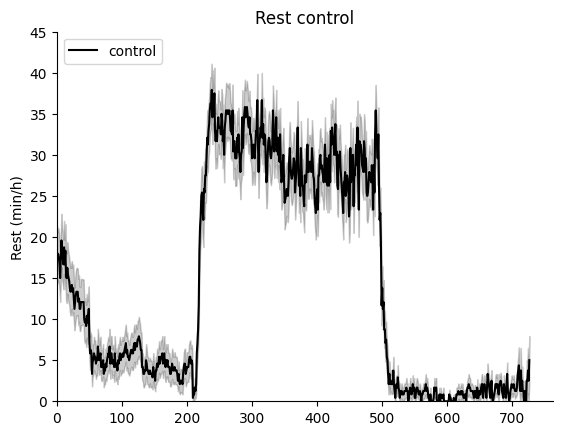

In [11]:
##Control
y = df_rest_control_hour.mean(axis=1)
x = np.linspace(0,len(y)-1,len(y))
print("len x",len(x))
print("len y",len(y))

# fit a linear curve and estimate its y-values and their error.
a, b = np.polyfit(x, y, deg=1)
y_est_ctrl = df_rest_control_hour.mean(axis=1)
y_err_ctrl = df_rest_control_hour.sem(axis=1)

fig, ax = plt.subplots()
ax.plot(x, y_est_ctrl, '-', color='black',label=ctrl_name)
ax.fill_between(x, y_est_ctrl - y_err_ctrl, y_est_ctrl + y_err_ctrl, alpha=0.2, color='black')

ax.set_xlim(0,)
ax.set_ylim(0,lim_y)
ax.set_title("Rest "+str(ctrl_name))
ax.set_ylabel("Rest (min/h)")
plt.legend(loc="upper left")
    
sns.despine(right=True, bottom=False)
fig.savefig(path_graphics+r"\Rest_pooled_"+ctrl_name+"_only.pdf")

len x 730
len y 730


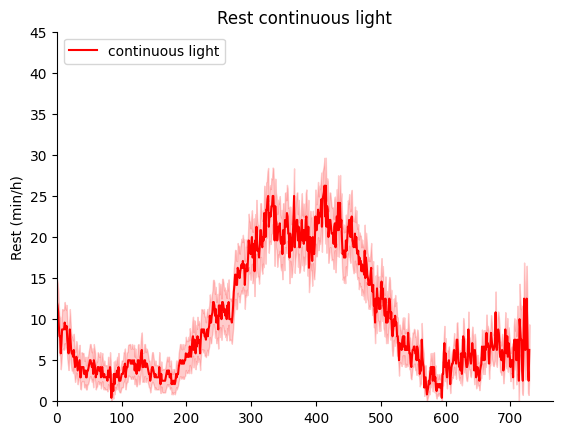

In [12]:
## Group 1
y = df_rest_continuouslight_hour.mean(axis=1)
x = np.linspace(0,len(y)-1,len(y))
print("len x",len(x))
print("len y",len(y))

# fit a linear curve and estimate its y-values and their error.
a, b = np.polyfit(x, y, deg=1)
y_est_cont = df_rest_continuouslight_hour.mean(axis=1)
y_err_cont = df_rest_continuouslight_hour.sem(axis=1)

fig, ax = plt.subplots()
ax.plot(x, y_est_cont, '-', color='red',label=group_1_name)
ax.fill_between(x, y_est_cont - y_err_cont, y_est_cont + y_err_cont, alpha=0.2, color='red')

ax.set_xlim(0,)
ax.set_ylim(0,lim_y)
ax.set_title("Rest "+str(group_1_name))
ax.set_ylabel("Rest (min/h)")
plt.legend(loc="upper left")
    
sns.despine(right=True, bottom=False)
fig.savefig(path_graphics+r"\Rest_pooled_"+str(group_1_name)+"_only.pdf")

len x 724
len y 724


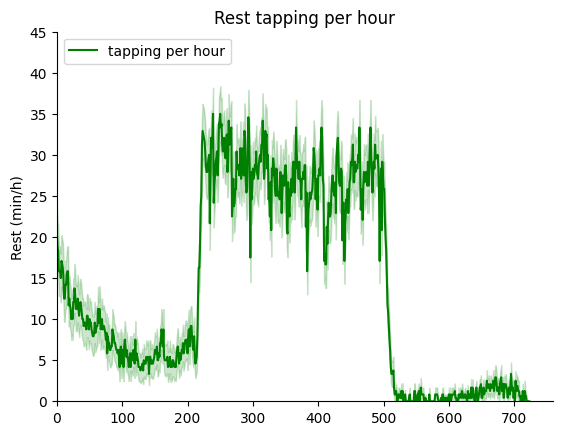

In [13]:
## Group 2
if group_nr>=3:
    y = df_rest_tapping_hour.mean(axis=1)
    x = np.linspace(0,len(y)-1,len(y))
    print("len x",len(x))
    print("len y",len(y))
    
    # fit a linear curve and estimate its y-values and their error.
    a, b = np.polyfit(x, y, deg=1)
    y_est_tap = df_rest_tapping_hour.mean(axis=1)
    y_err_tap = df_rest_tapping_hour.sem(axis=1)
    
    fig, ax = plt.subplots()
    ax.plot(x, y_est_tap, '-', color='green',label=group_2_name)
    ax.fill_between(x, y_est_tap - y_err_tap, y_est_tap + y_err_tap, alpha=0.2, color='green')
    
    ax.set_xlim(0,)
    ax.set_ylim(0,lim_y)
    ax.set_title("Rest "+str(group_2_name))
    ax.set_ylabel("Rest (min/h)")
    plt.legend(loc="upper left")
        
    sns.despine(right=True, bottom=False)
    fig.savefig(path_graphics+r"\Rest_pooled_"+group_2_name+"_only.pdf")

**Wake Activity Single Graphs**

len x 727
len y 727


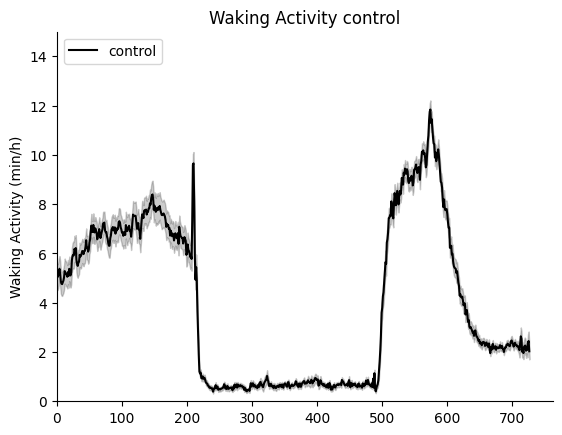

In [14]:
##Control
y = df_wakeAct_control_hour.mean(axis=1)
x = np.linspace(0,len(y)-1,len(y))
print("len x",len(x))
print("len y",len(y))

# fit a linear curve and estimate its y-values and their error.
a, b = np.polyfit(x, y, deg=1)
y_est_ctrl = df_wakeAct_control_hour.mean(axis=1)
y_err_ctrl = df_wakeAct_control_hour.sem(axis=1)

fig, ax = plt.subplots()
ax.plot(x, y_est_ctrl, '-', color='black',label=ctrl_name)
ax.fill_between(x, y_est_ctrl - y_err_ctrl, y_est_ctrl + y_err_ctrl, alpha=0.2, color='black')

ax.set_xlim(0,)
ax.set_ylim(0,lim_y_wake)
ax.set_title("Waking Activity "+ctrl_name)
ax.set_ylabel("Waking Activity (min/h)")
plt.legend(loc="upper left")
    
sns.despine(right=True, bottom=False)
fig.savefig(path_graphics+r"\WakeAct_pooled_"+ctrl_name+"_only.pdf")

len x 730
len y 730


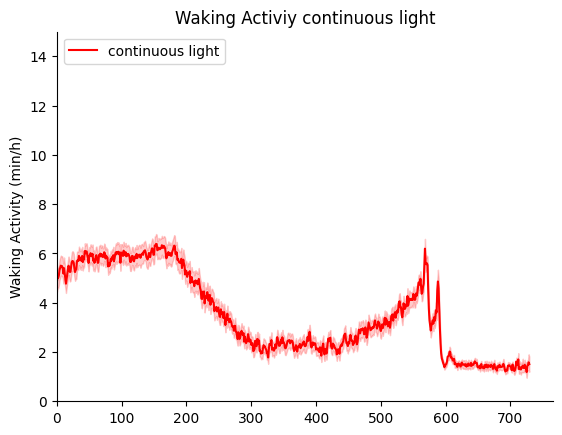

In [15]:
## Group 1
y = df_wakeAct_continuouslight_hour.mean(axis=1)
x = np.linspace(0,len(y)-1,len(y))
print("len x",len(x))
print("len y",len(y))

# fit a linear curve and estimate its y-values and their error.
a, b = np.polyfit(x, y, deg=1)
y_est_cont = df_wakeAct_continuouslight_hour.mean(axis=1)
y_err_cont = df_wakeAct_continuouslight_hour.sem(axis=1)

fig, ax = plt.subplots()
ax.plot(x, y_est_cont, '-', color='red',label=group_1_name)
ax.fill_between(x, y_est_cont - y_err_cont, y_est_cont + y_err_cont, alpha=0.2, color='red')

ax.set_xlim(0,)
ax.set_ylim(0,lim_y_wake)
ax.set_title("Waking Activiy "+group_1_name)
ax.set_ylabel("Waking Activity (min/h)")
plt.legend(loc="upper left")
    
sns.despine(right=True, bottom=False)
fig.savefig(path_graphics+r"\WakeAct_pooled_"+group_1_name+"_only.pdf")

len x 724
len y 724


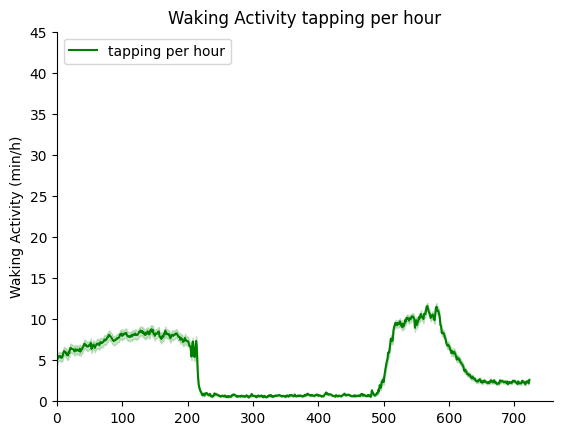

In [16]:
## Group2
if group_nr >= 3:
    y = df_wakeAct_tapping_hour.mean(axis=1)
    x = np.linspace(0,len(y)-1,len(y))
    print("len x",len(x))
    print("len y",len(y))
    
    # fit a linear curve and estimate its y-values and their error.
    a, b = np.polyfit(x, y, deg=1)
    y_est_tap = df_wakeAct_tapping_hour.mean(axis=1)
    y_err_tap = df_wakeAct_tapping_hour.sem(axis=1)
    
    fig, ax = plt.subplots()
    ax.plot(x, y_est_tap, '-', color='green',label=group_2_name)
    ax.fill_between(x, y_est_tap - y_err_tap, y_est_tap + y_err_tap, alpha=0.2, color='green')
    
    ax.set_xlim(0,)
    ax.set_ylim(0,lim_y)
    ax.set_title("Waking Activity "+group_2_name)
    ax.set_ylabel("Waking Activity (min/h)")
    plt.legend(loc="upper left")
        
    sns.despine(right=True, bottom=False)
    fig.savefig(path_graphics+r"\WakeAct_pooled_"+group_2_name+"_only.pdf")

## Double Graphics
One condition shown together with the control.

## Group 2 & Control

In [17]:
# Cut control to same length as group2
if group_nr >=3:
    if len(df_rest_control_hour)>len(df_rest_tapping_hour):
        stop = len(df_rest_control_hour)
        cut_helper = len(df_rest_tapping_hour)#length of your stimulus
        df_rest_control_hour = df_rest_control_hour.drop(labels=range(cut_helper,stop), axis = 0)
    else:
        stop = len(df_rest_tapping_hour)
        cut_helper = len(df_rest_control_hour)#length of your stimulus
        df_rest_tapping_hour = df_rest_tapping_hour.drop(labels=range(cut_helper,stop), axis = 0)

len x 724
len y 724


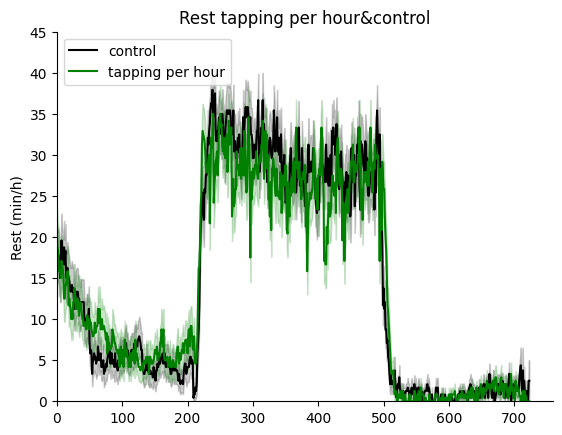

In [18]:
if group_nr >= 3:
    cut_helper_2 = len(df_rest_tapping_hour)-1
    
    y = df_rest_tapping_hour.mean(axis=1)
    x = np.arange(0, len(y), 1)
    print("len x",len(x))
    print("len y",len(y))
    
    
    
    # fit a linear curve an estimate its y-values and their error.
    a, b = np.polyfit(x, y, deg=1)
    y_est_ctrl = df_rest_control_hour.mean(axis=1)
    y_err_ctrl = df_rest_control_hour.sem(axis=1)
    
    y_est_tap=df_rest_tapping_hour.mean(axis=1)
    y_err_tap = df_rest_tapping_hour.sem(axis=1)
    
    
    fig, ax = plt.subplots()
    ax.plot(x, y_est_ctrl, '-', color='black',label=ctrl_name)
    ax.fill_between(x, y_est_ctrl - y_err_ctrl, y_est_ctrl + y_err_ctrl, alpha=0.2, color='black')
    
    ax.plot(x, y_est_tap, '-', color='green',label=group_2_name)
    ax.fill_between(x, y_est_tap - y_err_tap, y_est_tap + y_err_tap, alpha=0.2, color='green')
    
    #rectangle = plt.Rectangle((88,0),150, 60, fc='grey', alpha=0.2)
    #plt.gca().add_patch(rectangle)
    
    ax.set_xlim(0,)
    ax.set_ylim(0,lim_y)
    ax.set_title("Rest "+group_2_name+"&"+ctrl_name)
    
    ax.set_ylabel("Rest (min/h)")
    plt.legend(loc="upper left")
        
    sns.despine(right=True, bottom=False)
    fig.savefig(path_graphics+r"\Rest_pooled_"+group_2_name+"+"+ctrl_name+".pdf")

## Continuous & Control
To cut the control again, we first have to concatenate it anew and repeat the multiply step.

In [19]:
#concat controls
df_Act_control = pd.concat(act_ctrl_list, axis=1)
df_rest_control = pd.concat(rest_ctrl_list, axis=1)
df_wakeAct_control = pd.concat(wakeAct_ctrl_list, axis=1)

In [20]:
#hochrechnen auf 60 Minuten
df_rest_control_hour = df_rest_control.mul(tosixty)

In [21]:
# Cut control to same length as group 1
if len(df_rest_control_hour)>len(df_rest_continuouslight_hour):
    stop = len(df_rest_control_hour)
    cut_helper = len(df_rest_continuouslight_hour)#length of your stimulus
    df_rest_control_hour = df_rest_control_hour.drop(labels=range(cut_helper,stop), axis = 0)
else:
    stop = len(df_rest_continuouslight_hour)
    cut_helper = len(df_rest_control_hour)#length of your stimulus
    df_rest_continuouslight_hour = df_rest_continuouslight_hour.drop(labels=range(cut_helper,stop), axis = 0)

len x 727
len y 727


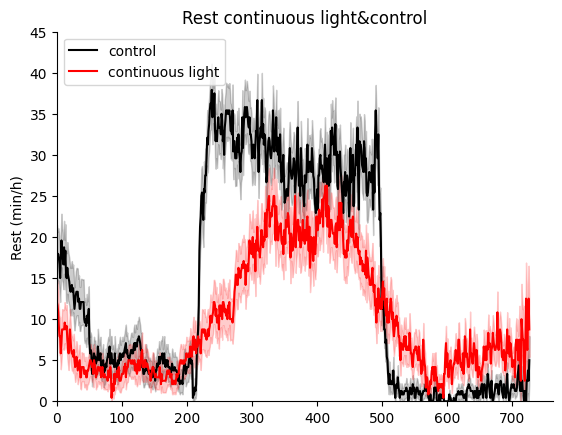

In [22]:
cut_helper_2 = len(df_rest_continuouslight_hour)-1

y = df_rest_continuouslight_hour.mean(axis=1)
x = np.linspace(0,cut_helper_2, cut_helper)
print("len x",len(x))
print("len y",len(y))

# fit a linear curve an estimate its y-values and their error.
a, b = np.polyfit(x, y, deg=1)
y_est_ctrl = df_rest_control_hour.mean(axis=1)
y_err_ctrl = df_rest_control_hour.sem(axis=1)

y_est_cont = df_rest_continuouslight_hour.mean(axis=1)
y_err_cont = df_rest_continuouslight_hour.sem(axis=1)


fig, ax = plt.subplots()
ax.plot(x, y_est_ctrl, '-', color='black',label=ctrl_name)
ax.fill_between(x, y_est_ctrl - y_err_ctrl, y_est_ctrl + y_err_ctrl, alpha=0.2, color='black')

ax.plot(x, y_est_cont, '-', color='red',label=group_1_name)
ax.fill_between(x, y_est_cont - y_err_cont, y_est_cont + y_err_cont, alpha=0.2, color='red')

#rectangle = plt.Rectangle((88,0),150, 60, fc='grey', alpha=0.2)
#plt.gca().add_patch(rectangle)

ax.set_xlim(0,)
ax.set_ylim(0,lim_y)
ax.set_title("Rest "+group_1_name+"&"+ctrl_name)

ax.set_ylabel("Rest (min/h)")
plt.legend(loc="upper left")
    
sns.despine(right=True, bottom=False)
fig.savefig(path_graphics+r"\Rest_pooled_"+group_1_name+"+"+ctrl_name+".pdf")

## **Double Graphics - Waking Activity**

## Control & Tapping

In [23]:
# Cut control to same length as group_2
if group_nr >=3:
    if len(df_wakeAct_control_hour)>len(df_wakeAct_tapping_hour):
        stop = len(df_wakeAct_control_hour)
        cut_helper = len(df_wakeAct_tapping_hour)#length of your stimulus
        df_wakeAct_control_hour = df_wakeAct_control_hour.drop(labels=range(cut_helper,stop), axis = 0)
    else:
        stop = len(df_wakeAct_tapping_hour)
        cut_helper = len(df_wakeAct_control_hour)#length of your stimulus
        df_wakeAct_tapping_hour = df_wakeAct_tapping_hour.drop(labels=range(cut_helper,stop), axis = 0)

len x 724
len y 724


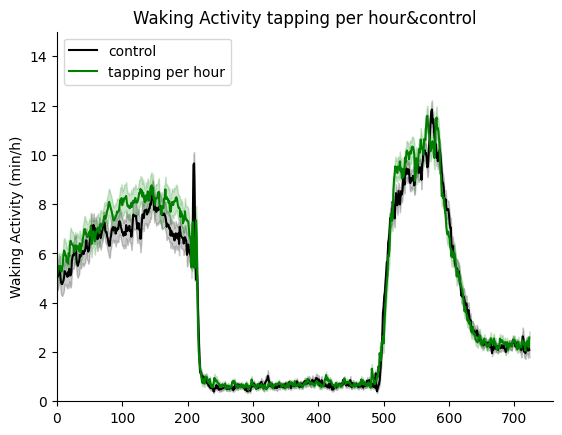

In [24]:
if group_nr >= 3:
    cut_helper_2 = len(df_wakeAct_tapping_hour)-1
    
    y = df_wakeAct_tapping_hour.mean(axis=1)
    x = np.arange(0, len(y), 1)
    print("len x",len(x))
    print("len y",len(y))
    
    
    
    # fit a linear curve an estimate its y-values and their error.
    a, b = np.polyfit(x, y, deg=1)
    y_est_ctrl = df_wakeAct_control_hour.mean(axis=1)
    y_err_ctrl = df_wakeAct_control_hour.sem(axis=1)
    
    y_est_tap=df_wakeAct_tapping_hour.mean(axis=1)
    y_err_tap = df_wakeAct_tapping_hour.sem(axis=1)
    
    
    fig, ax = plt.subplots()
    ax.plot(x, y_est_ctrl, '-', color='black',label=ctrl_name)
    ax.fill_between(x, y_est_ctrl - y_err_ctrl, y_est_ctrl + y_err_ctrl, alpha=0.2, color='black')
    
    ax.plot(x, y_est_tap, '-', color='green',label=group_2_name)
    ax.fill_between(x, y_est_tap - y_err_tap, y_est_tap + y_err_tap, alpha=0.2, color='green')
    
    #rectangle = plt.Rectangle((88,0),150, 60, fc='grey', alpha=0.2)
    #plt.gca().add_patch(rectangle)
    
    ax.set_xlim(0,)
    ax.set_ylim(0,lim_y_wake)
    ax.set_title("Waking Activity "+group_2_name+"&"+ctrl_name)
    
    ax.set_ylabel("Waking Activity (min/h)")
    plt.legend(loc="upper left")
        
    sns.despine(right=True, bottom=False)
    fig.savefig(path_graphics+r"\WakeAct_pooled_"+group_2_name+"+"+ctrl_name+".pdf")

## Continuous Light & Control

In [25]:
#concat controls
df_Act_control = pd.concat(act_ctrl_list, axis=1)
df_rest_control = pd.concat(rest_ctrl_list, axis=1)
df_wakeAct_control = pd.concat(wakeAct_ctrl_list, axis=1)

In [26]:
#hochrechnen auf 60 Minuten
df_rest_control_hour = df_rest_control.mul(1)

In [27]:
# Cut control to same length as continuous light
if len(df_wakeAct_control_hour)>len(df_wakeAct_continuouslight_hour):
    stop = len(df_wakeAct_control_hour)
    cut_helper = len(df_wakeAct_continuouslight_hour)#length of your stimulus
    df_wakeAct_control_hour = df_wakeAct_control_hour.drop(labels=range(cut_helper,stop), axis = 0)
else:
    stop = len(df_wakeAct_continuouslight_hour)
    cut_helper = len(df_wakeAct_control_hour)#length of your stimulus
    df_wakeAct_continuouslight_hour = df_wakeAct_continuouslight_hour.drop(labels=range(cut_helper,stop), axis = 0)

len x 724
len y 724


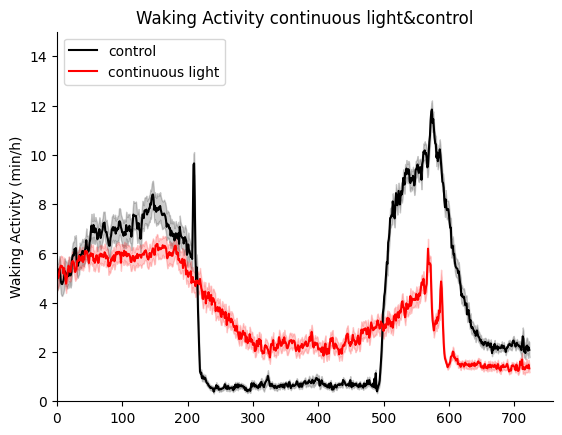

In [28]:
cut_helper_2 = len(df_wakeAct_continuouslight_hour)-1

y = df_wakeAct_continuouslight_hour.mean(axis=1)
x = np.linspace(0,cut_helper_2, cut_helper)
print("len x",len(x))
print("len y",len(y))

# fit a linear curve an estimate its y-values and their error.
a, b = np.polyfit(x, y, deg=1)
y_est_ctrl = df_wakeAct_control_hour.mean(axis=1)
y_err_ctrl = df_wakeAct_control_hour.sem(axis=1)

y_est_cont = df_wakeAct_continuouslight_hour.mean(axis=1)
y_err_cont = df_wakeAct_continuouslight_hour.sem(axis=1)


fig, ax = plt.subplots()
ax.plot(x, y_est_ctrl, '-', color='black',label=ctrl_name)
ax.fill_between(x, y_est_ctrl - y_err_ctrl, y_est_ctrl + y_err_ctrl, alpha=0.2, color='black')

ax.plot(x, y_est_cont, '-', color='red',label=group_1_name)
ax.fill_between(x, y_est_cont - y_err_cont, y_est_cont + y_err_cont, alpha=0.2, color='red')

#rectangle = plt.Rectangle((88,0),150, 60, fc='grey', alpha=0.2)
#plt.gca().add_patch(rectangle)

ax.set_xlim(0,)
ax.set_ylim(0,lim_y_wake)
ax.set_title("Waking Activity "+group_1_name+"&"+ctrl_name)

ax.set_ylabel("Waking Activity (min/h)")
plt.legend(loc="upper left")
    
sns.despine(right=True, bottom=False)
fig.savefig(path_graphics+r"\WakeAct_pooled_"+group_1_name+"+"+ctrl_name+".pdf")

## Bar plots - Rest
First, load the data & convert it into a dataframe.
You may have to add stuff here if you have more groups than 3.

In [29]:
#ctrl
i = 0
rest_night1_ctrl_list=list()
for key in ctrl_dict:
    rest_night1_ctrl_list.append(pd.read_csv(ctrl_dict[key]+r"\output_binned_rest_night1.csv", header=None))
    i= i+1
try:
    i = 0
    rest_day1_ctrl_list=list()
    for key in ctrl_dict:
        rest_day1_ctrl_list.append(pd.read_csv(ctrl_dict[key]+r"\output_binned_rest_day1.csv", header=None))
        i= i+1
except:
    pass
try:
    i = 0
    rest_testphase_ctrl_list=list()
    for key in ctrl_dict:
        rest_testphase_ctrl_list.append(pd.read_csv(ctrl_dict[key]+r"\output_binned_rest_testphase.csv", header=None))
        i= i+1
except:
    pass

#group1
i = 0
rest_night1_grp1_list=list()
for key in cont_dict:
    rest_night1_grp1_list.append(pd.read_csv(cont_dict[key]+r"\output_binned_rest_night1.csv", header=None))
    i= i+1
try:
    i = 0
    rest_day1_grp1_list=list()
    for key in cont_dict:
        rest_day1_grp1_list.append(pd.read_csv(cont_dict[key]+r"\output_binned_rest_day1.csv", header=None))
        i= i+1
except:
    pass
try:
    i = 0
    rest_testphase_grp1_list=list()
    for key in cont_dict:
        rest_testphase_grp1_list.append(pd.read_csv(cont_dict[key]+r"\output_binned_rest_testphase.csv", header=None))
        i= i+1
except:
    pass

if group_nr >=3:
    #group2
    i = 0
    rest_night1_grp2_list=list()
    for key in grp2_dict:
        rest_night1_grp2_list.append(pd.read_csv(grp2_dict[key]+r"\output_binned_rest_night1.csv", header=None))
        i= i+1
    try:
        i = 0
        rest_day1_grp2_list=list()
        for key in grp2_dict:
            rest_day1_grp2_list.append(pd.read_csv(grp2_dict[key]+r"\output_binned_rest_day1.csv", header=None))
            i= i+1
    except:
        pass
    try:
        i = 0
        rest_testphase_grp2_list=list()
        for key in grp2_dict:
            rest_testphase_grp2_list.append(pd.read_csv(grp2_dict[key]+r"\output_binned_rest_testphase.csv", header=None))
            i= i+1
    except:
        pass


## Concatenate

In [30]:
#concat controls
df_rest_control_night1_concat = pd.concat(rest_night1_ctrl_list, axis=1)
if len(rest_day1_ctrl_list)!=0:
    df_rest_control_day1_concat = pd.concat(rest_day1_ctrl_list, axis=1)
if len(rest_testphase_ctrl_list)!=0:
    df_rest_control_rebound_concat = pd.concat(rest_testphase_ctrl_list, axis=1)

In [31]:
#concat group2
df_rest_continuouslight_night1_concat = pd.concat(rest_night1_grp1_list, axis=1)
if len(rest_day1_grp1_list)!=0:
    df_rest_continuouslight_day1_concat = pd.concat(rest_day1_grp1_list, axis=1)
if len(rest_testphase_grp1_list)!=0:
    df_rest_continuouslight_rebound_concat = pd.concat(rest_testphase_grp1_list, axis=1)

In [32]:
#concat group3
if group_nr >=3:
    df_rest_tapping_night1_concat = pd.concat(rest_night1_grp2_list, axis=1)
    if len(rest_day1_grp2_list)!=0:
        df_rest_tapping_day1_concat = pd.concat(rest_day1_grp2_list, axis=1)
    if len(rest_testphase_grp2_list)!=0:
        df_rest_tapping_rebound_concat = pd.concat(rest_testphase_grp2_list, axis=1)

## Mean per fish
Get the column averages (which are the means per fish).
Skip the NaNs.

In [33]:
#control
mean_df_rest_control_night1 = df_rest_control_night1_concat.mean(axis=0,skipna=True)
try:
    mean_df_rest_control_day1 = df_rest_control_day1_concat.mean(axis=0,skipna=True)
except:
    pass
try:
    mean_df_rest_control_rebound = df_rest_control_rebound_concat.mean(axis=0,skipna=True)
except:
    pass

In [34]:
#group1
mean_df_rest_continuouslight_night1 = df_rest_continuouslight_night1_concat.mean(axis=0,skipna=True)
try:
    mean_df_rest_continuouslight_day1 = df_rest_continuouslight_day1_concat.mean(axis=0,skipna=True)
except:
    pass
try:
    mean_df_rest_continuouslight_rebound = df_rest_continuouslight_rebound_concat.mean(axis=0,skipna=True)
except:
    pass

In [35]:
#group2
if group_nr >=3:
    mean_df_rest_tapping_night1 = df_rest_tapping_night1_concat.mean(axis=0,skipna=True)
    try:
        mean_df_rest_tapping_day1 = df_rest_tapping_day1_concat.mean(axis=0,skipna=True)
    except:
        pass
    try:
        mean_df_rest_tapping_rebound = df_rest_tapping_rebound_concat.mean(axis=0,skipna=True)
    except:
        pass

## Multiply time to 60 minutes
Changes the unit for rest from minute/binned minutes to minute/hour.
This calculation uses the binned time from the beginning, so there may be errors in your data if you forgot to change the number accordingly!

In [36]:
tosixty = 60/binned

#control
df_rest_control_night1 = mean_df_rest_control_night1.mul(tosixty)
try:
    df_rest_control_day1 = mean_df_rest_control_day1.mul(tosixty)
except:
    pass
try:
    df_rest_control_rebound = mean_df_rest_control_rebound.mul(tosixty)
except:
    pass

#continuous light
df_rest_continuouslight_night1 = mean_df_rest_continuouslight_night1.mul(tosixty)
try:
    df_rest_continuouslight_day1 = mean_df_rest_continuouslight_day1.mul(tosixty)
except:
    pass
try:
    df_rest_continuouslight_rebound = mean_df_rest_continuouslight_rebound.mul(tosixty)
except:
    pass

if group_nr >=3:
    #group3
    df_rest_tapping_night1 = mean_df_rest_tapping_night1.mul(tosixty)
    try:
        df_rest_tapping_day1 = mean_df_rest_tapping_day1.mul(tosixty)
    except:
        pass
    try:
        df_rest_tapping_rebound = mean_df_rest_tapping_rebound.mul(tosixty)
    except:
        pass

## Bar plot graphics
All conditions together. <3

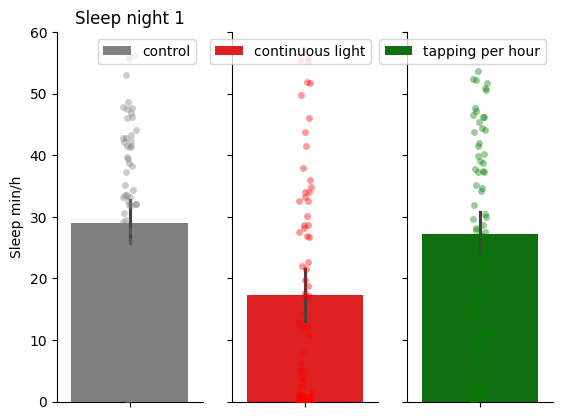

In [37]:
# Sleep Night 1
if group_nr == 2:
    fig, (ax1, ax2) = plt.subplots(1, group_nr, sharey=True)
elif group_nr ==3:
    fig, (ax1, ax2, ax3) = plt.subplots(1, group_nr, sharey=True)
ax = sns.barplot(ax=ax1,y=df_rest_control_night1, color = "grey", orient="v", label=ctrl_name)
ax = sns.stripplot(ax=ax1,data=df_rest_control_night1, dodge=True, color="grey", alpha = 0.4,jitter = 0.05)

ax = sns.barplot(ax=ax2, y=df_rest_continuouslight_night1, color = "red", orient="v", label=group_1_name)
ax = sns.stripplot(ax=ax2,data=df_rest_continuouslight_night1, dodge=True, color="red", alpha = 0.4,jitter = 0.05)

if group_nr >=3:
    ax = sns.barplot(ax=ax3, y=df_rest_tapping_night1, color = "green", orient="v", label=group_2_name)
    ax = sns.stripplot(ax=ax3,data=df_rest_tapping_night1, dodge=True, color="green", alpha = 0.4,jitter = 0.05)

ax1.set_title("Sleep night 1")
ax1.set_ylabel("Sleep min/h")
ax1.set_ylim(0,lim_y_bp_sleep)
sns.despine(right=True, bottom=False)
ax.legend()
fig.savefig(path_graphics+r"\Bar_plot_sleep_night1.pdf")

In [38]:
try: 
    with open(output_file, "a") as f:
        f.write("\n\n**Sleep night1**"+"\n")
        
    if group_nr == 2:
        list_dfs = [df_rest_control_night1, df_rest_continuouslight_night1]
        list_names = [ctrl_name, group_1_name]
        statistics(kruskal_var, output_file, list_dfs, list_names)
    elif group_nr == 3:
        list_dfs = [df_rest_control_night1, df_rest_continuouslight_night1, df_rest_tapping_night1]
        list_names = [ctrl_name, group_1_name, group_2_name]
        kruskal_var =statistics(kruskal_var, output_file, list_dfs, list_names) 
except:
    print("There seems to be an error or no data!")

Kruskal-Wallis H-test: Stats: 21.545323489280452 p-value: 2.0964883281908106e-05
                  continuous light   control  tapping per hour
continuous light          1.000000  0.000018          0.000235
control                   0.000018  1.000000          0.539598
tapping per hour          0.000235  0.539598          1.000000


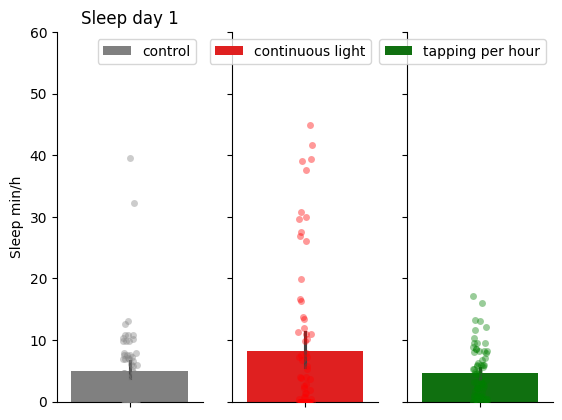

In [39]:
# Sleep Day 1
try:
    if group_nr == 2:
        fig, (ax1, ax2) = plt.subplots(1, group_nr, sharey=True)
    elif group_nr ==3:
        fig, (ax1, ax2, ax3) = plt.subplots(1, group_nr, sharey=True)
    ax = sns.barplot(ax=ax1,y=df_rest_control_day1, color = "grey", orient="v", label=ctrl_name)
    ax = sns.stripplot(ax=ax1,data=df_rest_control_day1, dodge=True, color="grey", alpha = 0.4,jitter = 0.05)
    
    ax = sns.barplot(ax=ax2, y=df_rest_continuouslight_day1, color = "red", orient="v", label=group_1_name)
    ax = sns.stripplot(ax=ax2,data=df_rest_continuouslight_day1, dodge=True, color="red", alpha = 0.4,jitter = 0.05)
    
    if group_nr >=3:
        ax = sns.barplot(ax=ax3, y=df_rest_tapping_day1, color = "green", orient="v", label=group_2_name)
        ax = sns.stripplot(ax=ax3,data=df_rest_tapping_day1, dodge=True, color="green", alpha = 0.4,jitter = 0.05)
    
    ax1.set_title("Sleep day 1")
    ax1.set_ylabel("Sleep min/h")
    ax1.set_ylim(0,lim_y_bp_sleep)
    sns.despine(right=True, bottom=False)
    ax.legend()
    fig.savefig(path_graphics+r"\Bar_plot_sleep_day1.pdf")
except:
    pass

In [40]:
try: 
    with open(output_file, "a") as f:
        f.write("\n\n**Sleep day1**"+"\n")
        
    if group_nr == 2:
        list_dfs = [df_rest_control_day1, df_rest_continuouslight_day1]
        list_names = [ctrl_name, group_1_name]
        statistics(kruskal_var, output_file, list_dfs, list_names)
    elif group_nr == 3:
        list_dfs = [df_rest_control_day1, df_rest_continuouslight_day1, df_rest_tapping_day1]
        list_names = [ctrl_name, group_1_name, group_2_name]
        kruskal_var =statistics(kruskal_var, output_file, list_dfs, list_names) 
except:
    print("There seems to be an error or no data!")

Kruskal-Wallis H-test: Stats: 0.9487891443912307 p-value: 0.6222616769660929
Your groups do not differ significantly from each other. A post-hoc test is not needed.


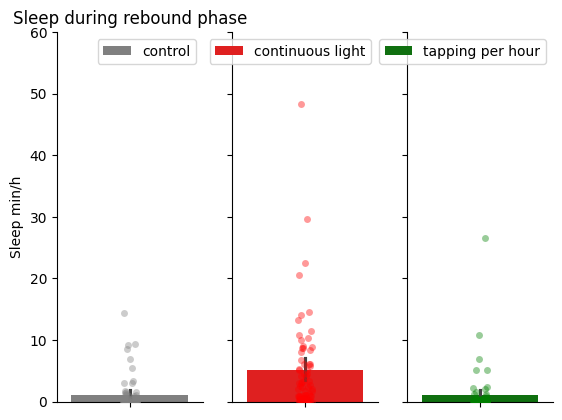

In [41]:
# Sleep Rebound Phase
try:
    if group_nr == 2:
        fig, (ax1, ax2) = plt.subplots(1, group_nr, sharey=True)
    elif group_nr ==3:
        fig, (ax1, ax2, ax3) = plt.subplots(1, group_nr, sharey=True)
    ax = sns.barplot(ax=ax1,y=df_rest_control_rebound, color = "grey", orient="v", label="control")
    ax = sns.stripplot(ax=ax1,data=df_rest_control_rebound, dodge=True, color="grey", alpha = 0.4,jitter = 0.05)
    
    ax = sns.barplot(ax=ax2, y=df_rest_continuouslight_rebound, color = "red", orient="v", label=group_1_name)
    ax = sns.stripplot(ax=ax2,data=df_rest_continuouslight_rebound, dodge=True, color="red", alpha = 0.4,jitter = 0.05)

    if group_nr >=3:
        ax = sns.barplot(ax=ax3, y=df_rest_tapping_rebound, color = "green", orient="v", label=group_2_name)
        ax = sns.stripplot(ax=ax3,data=df_rest_tapping_rebound, dodge=True, color="green", alpha = 0.4,jitter = 0.05)
    
    ax1.set_title("Sleep during rebound phase")
    ax1.set_ylabel("Sleep min/h")
    ax1.set_ylim(0,lim_y_bp_sleep)
    sns.despine(right=True, bottom=False)
    ax.legend()
    fig.savefig(path_graphics+r"\Bar_plot_sleep_rebound.pdf")
except:
    pass

In [42]:
try: 
    with open(output_file, "a") as f:
        f.write("\n\n**Sleep rebound phase**"+"\n")
        
    if group_nr == 2:
        list_dfs = [df_rest_control_rebound, df_rest_continuouslight_rebound]
        list_names = [ctrl_name, group_1_name]
        statistics(kruskal_var, output_file, list_dfs, list_names)
    elif group_nr == 3:
        list_dfs = [df_rest_control_rebound, df_rest_continuouslight_rebound, df_rest_tapping_rebound]
        list_names = [ctrl_name, group_1_name, group_2_name]
        kruskal_var =statistics(kruskal_var, output_file, list_dfs, list_names) 
except:
    print("There seems to be an error or no data!")

Kruskal-Wallis H-test: Stats: 57.5118430537292 p-value: 3.2468480080368435e-13
                  continuous light       control  tapping per hour
continuous light      1.000000e+00  5.675193e-10      5.875631e-12
control               5.675193e-10  1.000000e+00      4.943315e-01
tapping per hour      5.875631e-12  4.943315e-01      1.000000e+00


## Bar Graphs - Waking Activity

In [43]:
#ctrl
i = 0
wakeAct_night1_ctrl_list=list()
for key in ctrl_dict:
    wakeAct_night1_ctrl_list.append(pd.read_csv(ctrl_dict[key]+r"\output_binned_wakeAct_night1.csv", header=None))
    i= i+1
try:
    i = 0
    wakeAct_day1_ctrl_list=list()
    for key in ctrl_dict:
        wakeAct_day1_ctrl_list.append(pd.read_csv(ctrl_dict[key]+r"\output_binned_wakeAct_day1.csv", header=None))
        i= i+1
except:
    pass
try:
    i = 0
    wakeAct_testphase_ctrl_list=list()
    for key in ctrl_dict:
        wakeAct_testphase_ctrl_list.append(pd.read_csv(ctrl_dict[key]+r"\output_binned_wakeAct_testphase.csv", header=None))
        i= i+1
except:
    pass

#group1
i = 0
wakeAct_night1_grp1_list=list()
for key in cont_dict:
    wakeAct_night1_grp1_list.append(pd.read_csv(cont_dict[key]+r"\output_binned_wakeAct_night1.csv", header=None))
    i= i+1
try:
    i = 0
    wakeAct_day1_grp1_list=list()
    for key in cont_dict:
        wakeAct_day1_grp1_list.append(pd.read_csv(cont_dict[key]+r"\output_binned_wakeAct_day1.csv", header=None))
        i= i+1
except:
    pass
try:
    i = 0
    wakeAct_testphase_grp1_list=list()
    for key in cont_dict:
        wakeAct_testphase_grp1_list.append(pd.read_csv(cont_dict[key]+r"\output_binned_wakeAct_testphase.csv", header=None))
        i= i+1
except:
    pass

if group_nr >=3:
    #group2
    i = 0
    wakeAct_night1_grp2_list=list()
    for key in cont_dict:
        wakeAct_night1_grp2_list.append(pd.read_csv(grp2_dict[key]+r"\output_binned_wakeAct_night1.csv", header=None))
        i= i+1
    try:
        i = 0
        wakeAct_day1_grp2_list=list()
        for key in cont_dict:
            wakeAct_day1_grp2_list.append(pd.read_csv(grp2_dict[key]+r"\output_binned_wakeAct_day1.csv", header=None))
            i= i+1
    except:
        pass
    try:
        i = 0
        wakeAct_testphase_grp2_list=list()
        for key in grp2_dict:
            wakeAct_testphase_grp2_list.append(pd.read_csv(grp2_dict[key]+r"\output_binned_wakeAct_testphase.csv", header=None))
            i= i+1
    except:
        pass


## Concatenate

In [44]:
# concat controls
df_wakeAct_control_night1_concat = pd.concat(wakeAct_night1_ctrl_list, axis=1)
if len(wakeAct_day1_ctrl_list)!=0:
    df_wakeAct_control_day1_concat = pd.concat(wakeAct_day1_ctrl_list, axis=1)
if len(wakeAct_testphase_ctrl_list)!=0:
    df_wakeAct_control_rebound_concat = pd.concat(wakeAct_testphase_ctrl_list, axis=1)

In [45]:
# concat group1
df_wakeAct_continuouslight_night1_concat = pd.concat(wakeAct_night1_grp1_list, axis=1)
if len(wakeAct_day1_grp1_list)!=0:
    df_wakeAct_continuouslight_day1_concat = pd.concat(wakeAct_day1_grp1_list, axis=1)
if len(wakeAct_testphase_grp1_list)!=0:
    df_wakeAct_continuouslight_rebound_concat = pd.concat(wakeAct_testphase_grp1_list, axis=1)

In [46]:
#concat group2
try:
    # concat group1
    df_wakeAct_tapping_night1_concat = pd.concat(wakeAct_night1_grp2_list, axis=1)
    if len(wakeAct_day1_grp2_list)!=0:
        df_wakeAct_tapping_day1_concat = pd.concat(wakeAct_day1_grp2_list, axis=1)
    if len(wakeAct_testphase_grp2_list)!=0:
        df_wakeAct_tapping_rebound_concat = pd.concat(wakeAct_testphase_grp2_list, axis=1)
except:
    pass

## Mean per Fish

In [47]:
#control
df_wakeAct_control_night1 = df_wakeAct_control_night1_concat.mean(axis=0,skipna=True)
try:
    df_wakeAct_control_day1 = df_wakeAct_control_day1_concat.mean(axis=0,skipna=True)
except:
    pass
try:
    df_wakeAct_control_rebound = df_wakeAct_control_rebound_concat.mean(axis=0,skipna=True)
except:
    pass

In [48]:
#continuous light
df_wakeAct_continuouslight_night1 = df_wakeAct_continuouslight_night1_concat.mean(axis=0,skipna=True)
try:
    df_wakeAct_continuouslight_day1 = df_wakeAct_continuouslight_day1_concat.mean(axis=0,skipna=True)
except:
    pass
try:
    df_wakeAct_continuouslight_rebound = df_wakeAct_continuouslight_rebound_concat.mean(axis=0,skipna=True)
except:
    pass

In [49]:
#tapping
try:
    df_wakeAct_tapping_night1 = df_wakeAct_tapping_night1_concat.mean(axis=0,skipna=True)
    try:
        df_wakeAct_tapping_day1 = df_wakeAct_tapping_day1_concat.mean(axis=0,skipna=True)
    except:
        pass
    try:
        df_wakeAct_tapping_rebound = df_wakeAct_tapping_rebound_concat.mean(axis=0,skipna=True)
    except:
        pass
except:
    pass

## Bar plots

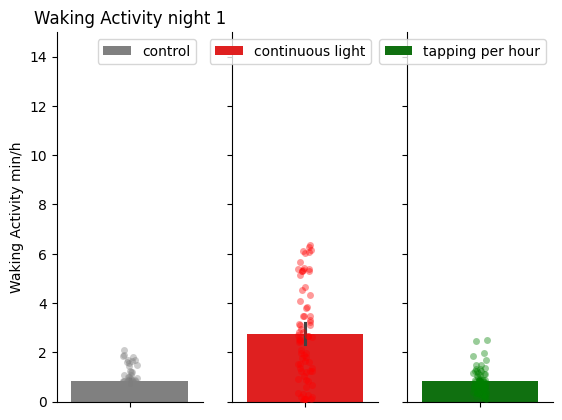

In [50]:
# Waking Activity Night 1

if group_nr == 2:
    fig, (ax1, ax2) = plt.subplots(1, group_nr, sharey=True)
elif group_nr ==3:
    fig, (ax1, ax2, ax3) = plt.subplots(1, group_nr, sharey=True)
ax = sns.barplot(ax=ax1,y=df_wakeAct_control_night1, color = "grey", orient="v", label=ctrl_name)
ax = sns.stripplot(ax=ax1,data=df_wakeAct_control_night1, dodge=True, color="grey", alpha = 0.4,jitter = 0.05)

ax = sns.barplot(ax=ax2, y=df_wakeAct_continuouslight_night1, color = "red", orient="v", label=group_1_name)
ax = sns.stripplot(ax=ax2,data=df_wakeAct_continuouslight_night1, dodge=True, color="red", alpha = 0.4,jitter = 0.05)
if group_nr >=3:
    ax = sns.barplot(ax=ax3, y=df_wakeAct_tapping_night1, color = "green", orient="v", label=group_2_name)
    ax = sns.stripplot(ax=ax3,data=df_wakeAct_tapping_night1, dodge=True, color="green", alpha = 0.4,jitter = 0.05)

ax1.set_title("Waking Activity night 1")
ax1.set_ylabel("Waking Activity min/h")
ax1.set_ylim(0,lim_y_bp_wake)
sns.despine(right=True, bottom=False)
ax.legend()
fig.savefig(path_graphics+r"\Bar_plot_wakeAct_night1.pdf")

In [51]:
try: 
    with open(output_file, "a") as f:
        f.write("\n\n**Waking Activity night 1**"+"\n")
        
    if group_nr == 2:
        list_dfs = [df_wakeAct_control_night1, df_wakeAct_continuouslight_night1]
        list_names = [ctrl_name, group_1_name]
        statistics(kruskal_var, output_file, list_dfs, list_names)
    elif group_nr == 3:
        list_dfs = [df_wakeAct_control_night1, df_wakeAct_continuouslight_night1, df_wakeAct_tapping_night1]
        list_names = [ctrl_name, group_1_name, group_2_name]
        kruskal_var =statistics(kruskal_var, output_file, list_dfs, list_names) 
except:
    print("There seems to be an error or no data!")

Kruskal-Wallis H-test: Stats: 55.10057888149288 p-value: 1.0840799719763024e-12
                  continuous light       control  tapping per hour
continuous light      1.000000e+00  1.620908e-10      1.027332e-10
control               1.620908e-10  1.000000e+00      9.447225e-01
tapping per hour      1.027332e-10  9.447225e-01      1.000000e+00


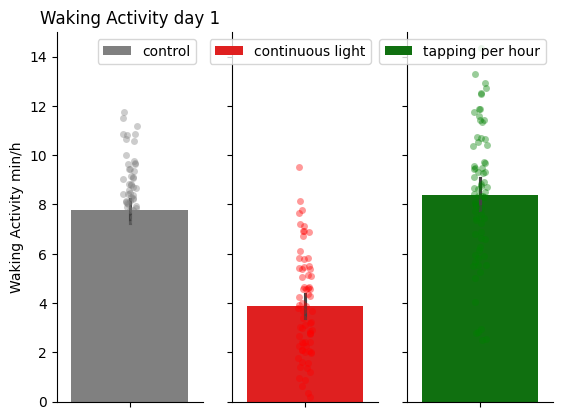

In [52]:
# Waking Activity Day 1
try:
    if group_nr == 2:
        fig, (ax1, ax2) = plt.subplots(1, group_nr, sharey=True)
    elif group_nr ==3:
        fig, (ax1, ax2, ax3) = plt.subplots(1, group_nr, sharey=True)
    ax = sns.barplot(ax=ax1,y=df_wakeAct_control_day1, color = "grey", orient="v", label=ctrl_name)
    ax = sns.stripplot(ax=ax1,data=df_wakeAct_control_day1, dodge=True, color="grey", alpha = 0.4,jitter = 0.05)
    
    ax = sns.barplot(ax=ax2, y=df_wakeAct_continuouslight_day1, color = "red", orient="v", label=group_1_name)
    ax = sns.stripplot(ax=ax2,data=df_wakeAct_continuouslight_day1, dodge=True, color="red", alpha = 0.4,jitter = 0.05)

    if group_nr >=3:
        ax = sns.barplot(ax=ax3, y=df_wakeAct_tapping_day1, color = "green", orient="v", label=group_2_name)
        ax = sns.stripplot(ax=ax3,data=df_wakeAct_tapping_day1, dodge=True, color="green", alpha = 0.4,jitter = 0.05)
    
    ax1.set_title("Waking Activity day 1")
    ax1.set_ylabel("Waking Activity min/h")
    ax1.set_ylim(0,lim_y_bp_wake)
    sns.despine(right=True, bottom=False)
    ax.legend()
    fig.savefig(path_graphics+r"\Bar_plot_wakeAct_day1.pdf")
except:
    pass

In [53]:
try: 
    with open(output_file, "a") as f:
        f.write("\n\n**Waking Activity day 1**"+"\n")
        
    if group_nr == 2:
        list_dfs = [df_wakeAct_control_day1, df_wakeAct_continuouslight_day1]
        list_names = [ctrl_name, group_1_name]
        statistics(kruskal_var, output_file, list_dfs, list_names)
    elif group_nr == 3:
        list_dfs = [df_wakeAct_control_day1, df_wakeAct_continuouslight_day1, df_wakeAct_tapping_day1]
        list_names = [ctrl_name, group_1_name, group_2_name]
        kruskal_var =statistics(kruskal_var, output_file, list_dfs, list_names) 
except:
    print("There seems to be an error or no data!")

Kruskal-Wallis H-test: Stats: 93.4544361950276 p-value: 5.088936427359545e-21
                  continuous light       control  tapping per hour
continuous light      1.000000e+00  5.216290e-15      1.037911e-18
control               5.216290e-15  1.000000e+00      3.127993e-01
tapping per hour      1.037911e-18  3.127993e-01      1.000000e+00


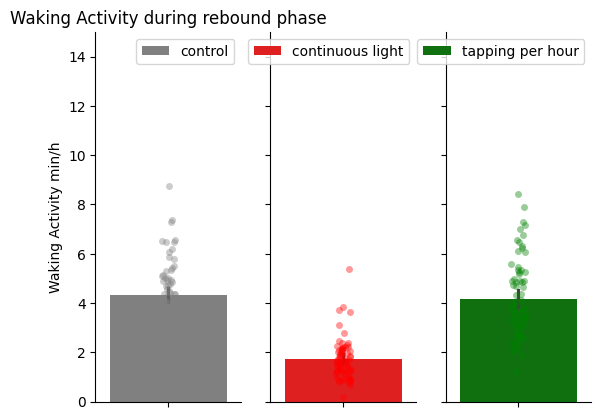

In [54]:
# Sleep Rebound Phase
try:
    if group_nr == 2:
        fig, (ax1, ax2) = plt.subplots(1, group_nr, sharey=True)
    elif group_nr ==3:
        fig, (ax1, ax2, ax3) = plt.subplots(1, group_nr, sharey=True)
    ax = sns.barplot(ax=ax1,y=df_wakeAct_control_rebound, color = "grey", orient="v", label=ctrl_name)
    ax = sns.stripplot(ax=ax1,data=df_wakeAct_control_rebound, dodge=True, color="grey", alpha = 0.4,jitter = 0.05)
    
    ax = sns.barplot(ax=ax2, y=df_wakeAct_continuouslight_rebound, color = "red", orient="v", label=group_1_name)
    ax = sns.stripplot(ax=ax2,data=df_wakeAct_continuouslight_rebound, dodge=True, color="red", alpha = 0.4,jitter = 0.05)
    
    if group_nr >=3:
        ax = sns.barplot(ax=ax3, y=df_wakeAct_tapping_rebound, color = "green", orient="v", label=group_2_name)
        ax = sns.stripplot(ax=ax3,data=df_wakeAct_tapping_rebound, dodge=True, color="green", alpha = 0.4,jitter = 0.05)
        
    ax1.set_title("Waking Activity during rebound phase")
    ax1.set_ylabel("Waking Activity min/h")
    ax1.set_ylim(0,lim_y_bp_wake)
    sns.despine(right=True, bottom=False)
    ax.legend()
    fig.savefig(path_graphics+r"\Bar_plot_wakeAct_rebound.pdf")
except:
    pass

In [55]:
try:
    with open(output_file, "a") as f:
        f.write("\n\n**Waking Activity rebound phase**"+"\n")
         
    if group_nr == 2:
        list_dfs = [df_wakeAct_control_rebound, df_wakeAct_continuouslight_rebound]
        list_names = [ctrl_name, group_1_name]
        statistics(kruskal_var, output_file, list_dfs, list_names)
    elif group_nr == 3:
        list_dfs = [df_wakeAct_control_rebound, df_wakeAct_continuouslight_rebound, df_wakeAct_tapping_rebound]
        list_names = [ctrl_name, group_1_name, group_2_name]
        kruskal_var = statistics(kruskal_var, output_file, list_dfs, list_names) 
except:
    print("There seems to be an error or no data!")

Kruskal-Wallis H-test: Stats: 115.50214058144161 p-value: 8.299058935624751e-26
                  continuous light       control  tapping per hour
continuous light      1.000000e+00  3.336917e-22      7.252416e-19
control               3.336917e-22  1.000000e+00      4.129617e-01
tapping per hour      7.252416e-19  4.129617e-01      1.000000e+00
